In [ ]:
#!pip install httpx
#!pip install num2words
#!pip install nest-asyncio
#!pip install gapic-google-cloud-speech-v1beta1
#!pip install google-cloud
#!pip install --upgrade google-cloud-speech
#!pip install jiwer

In [1]:
from report_helpers import download_dataset
from report_helpers import transcribe_vosk
from report_helpers import transcribe_google
from report_helpers import transcribe_whisper
from report_helpers import evaluate
from report_helpers import plot
from report_helpers import comparator
from report_helpers import examples
import pandas as pd
import os
import re

In [2]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

### Load local dataset

In [ ]:
df = pd.read_csv('df.csv')

### Prepare dataset

In [ ]:
data_path = './data/'
archive_file_name = 'data_2021_11_23.zip'
URL = 'http://langtea.club/datasets/vosk/'+archive_file_name

In [ ]:
download_dataset(URL, data_path, archive_file_name)

### Human transcribation

In [ ]:
df = pd.read_csv(data_path+'data_0.csv', header = 0, sep=';')
df['path'] = 'data/audio'

In [ ]:
for id_, row in df.iloc()[0].items():
    print('\n'+str(id_)+':')
    print(row)

### Machine transcribation

In [ ]:
# vosk 1
server = 'ws://192.168.1.23:2700'
transcribations = []
for path, file in df[['path', 'file']].values:
    print(len(transcribations), file)
    phrases = asyncio.get_event_loop().run_until_complete(
        transcribe_vosk(path+'/'+file, server)
    )
    transcribations.append(' '.join([str(item) for item in phrases]))
df['vosk1_text'] = transcribations

In [ ]:
df.to_csv('df.csv')

In [ ]:
# vosk 2
server = 'ws://10.2.4.87:2700'
transcribations = []
for path, file in df[['path', 'file']].values:
    print(len(transcribations), file)
    phrases = asyncio.get_event_loop().run_until_complete(
        transcribe_vosk(path+'/'+file, server)
    )
    transcribations.append(' '.join([str(item) for item in phrases]))
df['vosk2_text'] = transcribations

In [ ]:
df.to_csv('df.csv')

In [ ]:
# google
#df = pd.read_csv('df.csv')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'google_app_cred.json'
transcribations = []
for path, file in df[['path', 'file']].values:
    print(len(transcribations), file)
    transcribations.append(transcribe_google(path + '/' + file))
df['google_text'] = transcribations

In [ ]:
df.to_csv('df.csv')

In [21]:
def process_transcriptions(df, server_url, column, phrases_to_remove=None):
    transcribations = []
    for path, file in df[['path', 'file']].values:
        phrases = asyncio.get_event_loop().run_until_complete(
            transcribe_whisper(path+'/'+file, server_url)
            )
        transcribations.append(' '.join([str(item) for item in phrases]))
    for phrase in phrases_to_remove:
        for t in transcribations:
            t = re.sub(phrase, "", t)
    df[column] = transcribations

In [22]:
server_url = 'http://localhost:8888/transcribe'

phrases_to_remove = [
    "телефонный звонок",
    "звонит мобильный телефон",
    "звонит телефон",
]

In [4]:
# whisper v3
column = 'whisper_v3_text'
process_transcriptions(
    df,
    server_url,
    column,
    phrases_to_remove
)

In [5]:
df.to_csv('df.csv')

In [7]:
# whisper v2
column = 'whisper_v2_text'
process_transcriptions(
    df,
    server_url,
    column,
    phrases_to_remove
)

In [32]:
df.to_csv('df.csv')

In [23]:
# whisper v2 ru
column = 'whisper_v3_text'
process_transcriptions(
    df,
    server_url,
    column,
    phrases_to_remove
)

### eval

In [ ]:
evaluate(df, 'vosk1')
evaluate(df, 'vosk2')
evaluate(df, 'google')

In [41]:
evaluate(df, 'whisper_v3')
evaluate(df, 'whisper_v2')
evaluate(df, 'whisper_v2_ru')

### save data

In [42]:
df.to_csv('data_full.csv', index=False)

### load data

In [43]:
df = pd.read_csv('data_full.csv')

### plot

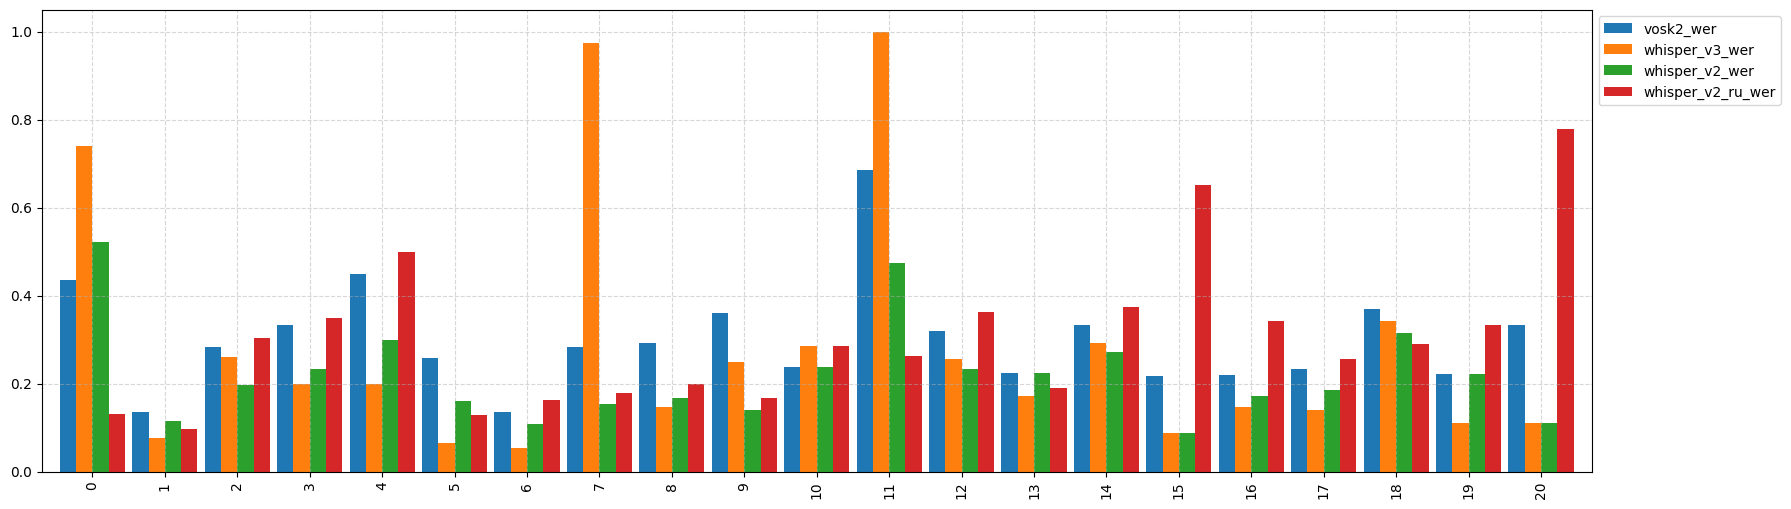

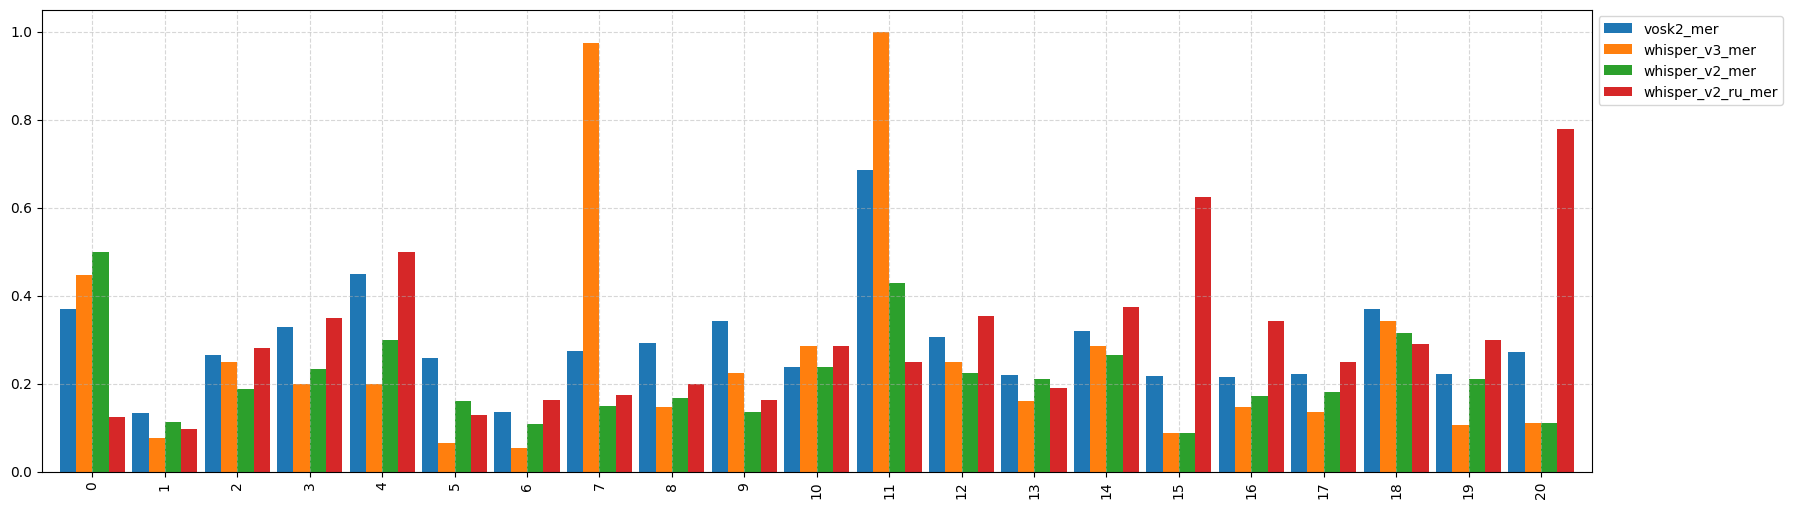

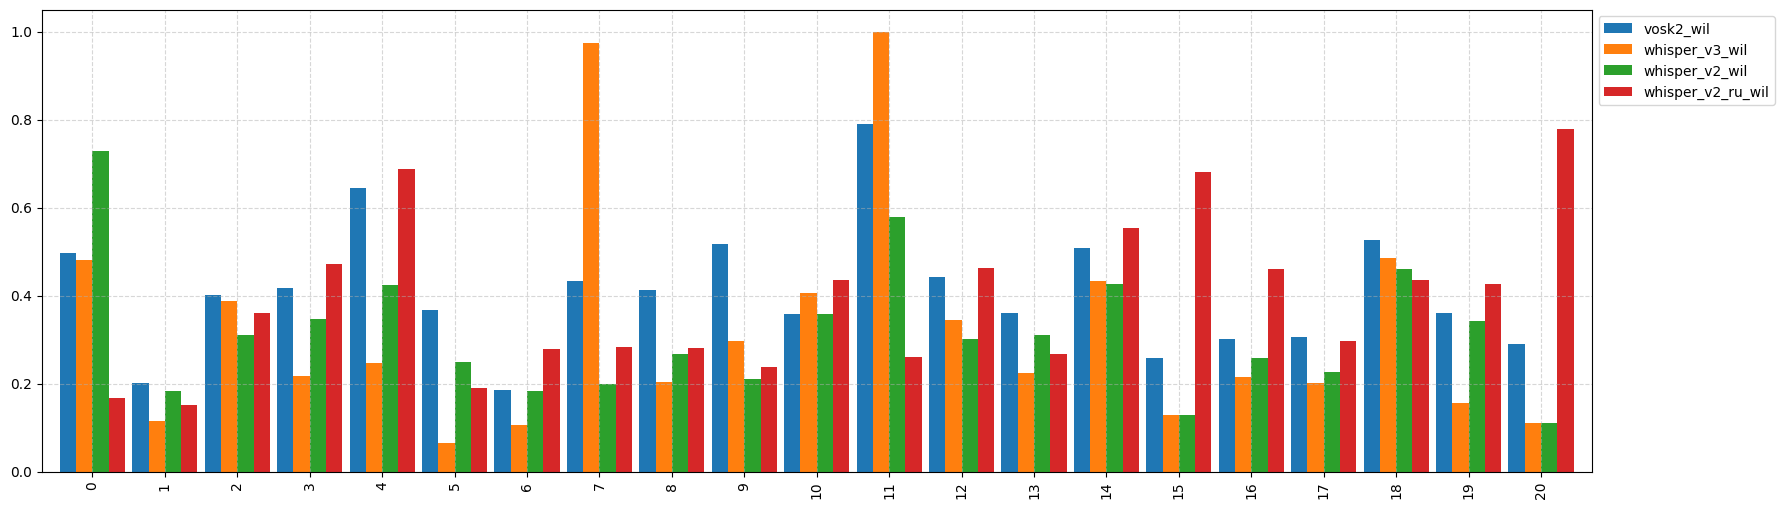

In [44]:
plot(df, ['vosk2', 'whisper_v3', 'whisper_v2', 'whisper_v2_ru'])

### Aggregate median and compare

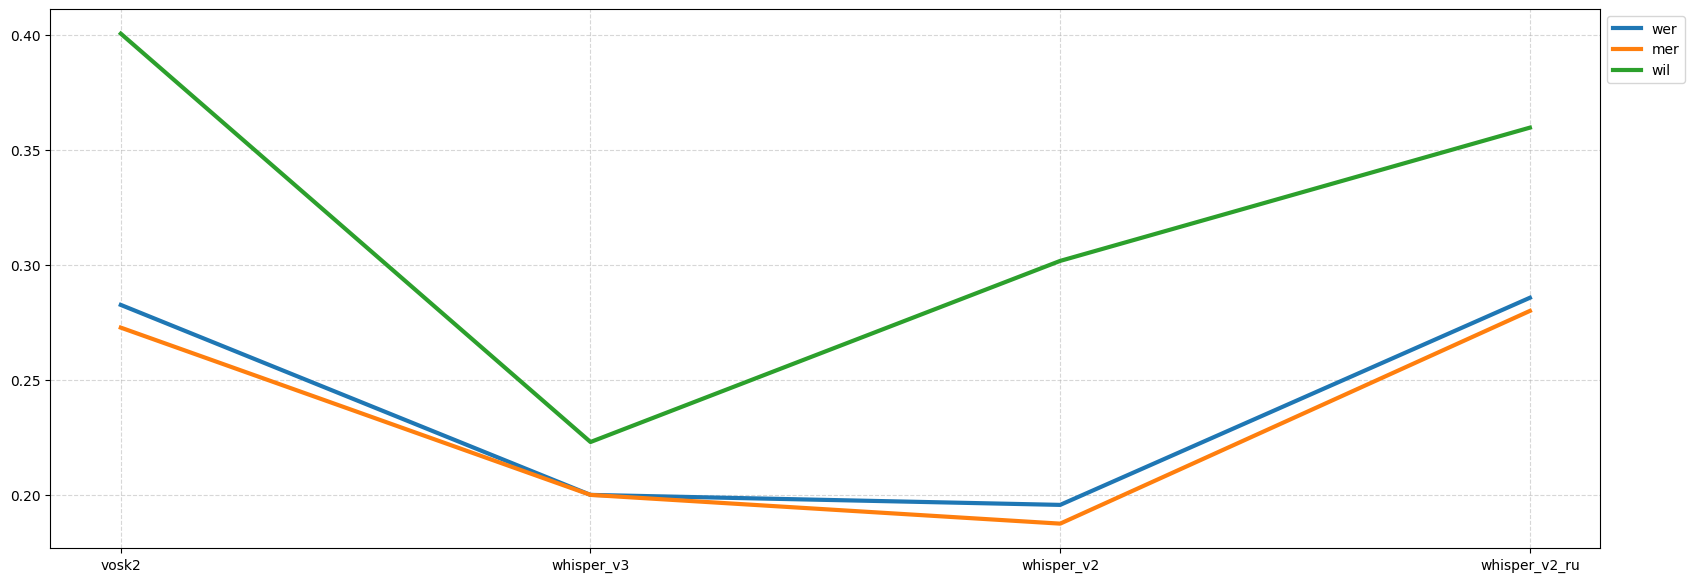


wer:
vosk2 0.2826086956521739
whisper_v3 0.2
whisper_v2 0.1956521739130435
whisper_v2_ru 0.2857142857142857

mer:
vosk2 0.2727272727272727
whisper_v3 0.2
whisper_v2 0.1875
whisper_v2_ru 0.28

wil:
vosk2 0.400555041628122
whisper_v3 0.2229885057471263
whisper_v2 0.3017408123791103
whisper_v2_ru 0.3596837944664031


In [45]:
comparator(
    df = df,
    engines = ['vosk2', 'whisper_v3', 'whisper_v2', 'whisper_v2_ru'],
    evals = ['wer', 'mer', 'wil']
)

### Word Error Rate
The present de facto standard index for ASR system assessment is the Word Error Rate, which is defined as the proportion of word errors to
words processed
### Match error rate
Probability of a given match being incorrect
### Word information lost
Simple function of HSDI counts by making use of an equation linking mutual information with Pearson's Large Sample Statistic, and then retaining only dominant terms.

### Conclusion
MER and WIL both provide simple CSR performance measures which vary from 0 when there are no errors to 1 when
there are no hits. They are more suitable than WER for the evaluation of any application in which the proportion of word information communicated is more meaningful than edit cost.   
At low error rates all three give similar scores so that the inappropriate theoretical basis for the WER measure is not noticeable. However, in tests for many real world applications, where significant error rates are common and choosing the best system is very important, the rankings given by each measure start to differ significantly and the risk of incorrect choice of best performing system becomes very real. Statistical tests used with WER can also be applied to MER and WIL. Both MER and WIL have intuitively simple probabilistic interpretations, but in so far as WIL measures the proportion of (mapping sensitive) word information communicated (at least, when N is dominated by H), and communication is mainly what speech is for, it is the preferred measure.
   
<a href="https://www.researchgate.net/publication/221478089_From_WER_and_RIL_to_MER_and_WIL_improved_evaluation_measures_for_connected_speech_recognition">From_WER_and_RIL_to_MER_and_WIL_improved_evaluatio.pdf</a>


In [40]:
examples(
    df,
    ['human', 'vosk2', 'whisper_v3', 'whisper_v2', 'whisper_v2_ru'],
    0
)


=== example 0 ===

human:
алло доброе утро компания айсберг мастер юсупов по поводу обоев актулаьно еще хорошо я тогда продлю заявку а могу закрывать а ага хорошо

vosk2:
алло доброе утро компания айсберг марш три юсупов по поводу обоих актуальнее чем нет нет хорошо я тогда продлю заявку а мого могу закрывать хорошо

whisper_v3:
алло доброе утро компания айсберг мастер юсупов по поводу обоев актуально еще нет нет я же сказала что надо будет это регулярно ну хорошо я тогда продлю заявку нет все а могу закрывать что ли а хорошо

whisper_v2:
алло доброе утро компания айсберг мастер юсупов по поводу обоев актуально еще нет нет я же сказала что надо мне перезвонить нет все

whisper_v2_ru:
алло доброе утро компания айсберг мастер юсупов по поводу обоев актуально еще хорошо я тогда продлю заявку а могу могу закрывать а хорошо

=== example 1 ===

human:
а добрый день меня зовут иван мастер по холодильникам хотел с вами время визита согласовать я постараюсь побыстрее но ориентировочно до одина